# Colima Inversion Examples



In [21]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format

In [22]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF00-04a,1499,1506,625.8,60,19,31,18,11,6,2,1,1,1,"2,124.86"
18,VF00-06a3,1957,1997,417.2,40,7,30,25,17,11,5,1,1,1,"2,796.04"
17,VF00-05a3,1787,2173,500.64,48,10,30,24,16,9,3,1,1,1,"2,813.41"
37,VF06-03/5-09,-770,3082,594.51,57,11,25,25,19,11,4,1,1,1,"3,176.73"
31,VF05-08a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,1,1,"3,568.48"


## Preprossessing Steps

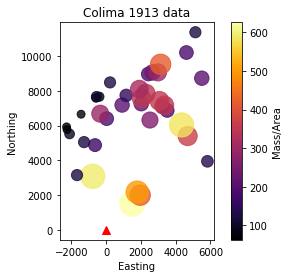

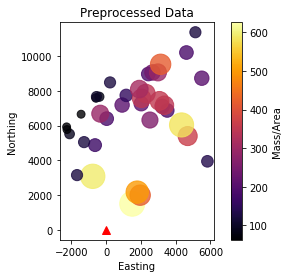

In [23]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [24]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.73,23.1529,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.0103587,"2,124.86",117.087
18,1957,1997,0,691.154,21.3541,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.0128943,"2,796.04",165.665
17,1787,2173,0,709.841,21.2137,24.71,22.4801,16.6062,9.88889,3.93999,0.980849,0.16722,0.013114,"2,813.41",141.787
37,-770,3082,0,301.066,13.8022,19.2173,22.1297,20.4626,14.7247,7.12663,2.10569,0.398324,0.0329064,"3,176.73",50.641
31,-1673,3152,0,149.68,9.51561,14.8613,20.3208,22.2637,18.4942,10.3172,3.45994,0.706562,0.0606982,"3,568.48",119.591


In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,1394.460,17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,0.000028,2124.861643,222.828380
18,1957,1997,2500,1216.150,14.0160,22.3619,24.8640,20.2838,12.7356,4.93885,0.769130,0.030705,0.000063,2796.043276,291.502876
17,1787,2173,2500,1251.000,13.8770,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.031310,0.000064,2813.413940,249.880153
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.041096,0.000091,3176.731654,60.452978
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.079070,0.054478,0.000132,3568.477687,107.303452


In [6]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0
5,0.5,1233.5,"[0,1)",0.0,0.125474,1.0
6,1.5,1443.0,"[1,2)",1.0,0.084166,2.0
7,2.5,1652.5,"[2,3)",2.0,0.047459,3.0
8,3.5,1862.0,"[3,4)",3.0,0.022496,4.0


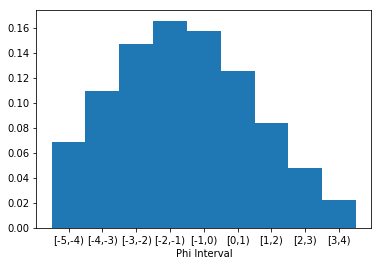

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.06250 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,17.023654,24.058691,24.746126,19.010648,10.986457,3.680616,0.476505,0.017266,0.000036,1316.804462,2124.861643,210.419377
1,1997,1957,13.849036,22.187896,24.802962,20.364657,12.884741,5.062941,0.813217,0.034469,0.000080,1148.987823,2796.043276,275.404560
2,2173,1787,13.800371,22.209864,24.864958,20.379976,12.855621,5.043105,0.811521,0.034502,0.000081,1166.987337,2813.413940,233.099101
3,3082,-770,15.561092,23.674710,24.901902,19.059630,11.448421,4.522511,0.794749,0.036892,0.000093,300.904559,3176.731654,50.613877
4,3152,-1673,16.255639,24.321103,24.942842,18.429623,10.768184,4.367639,0.869463,0.045380,0.000126,111.014810,3568.477687,88.698314


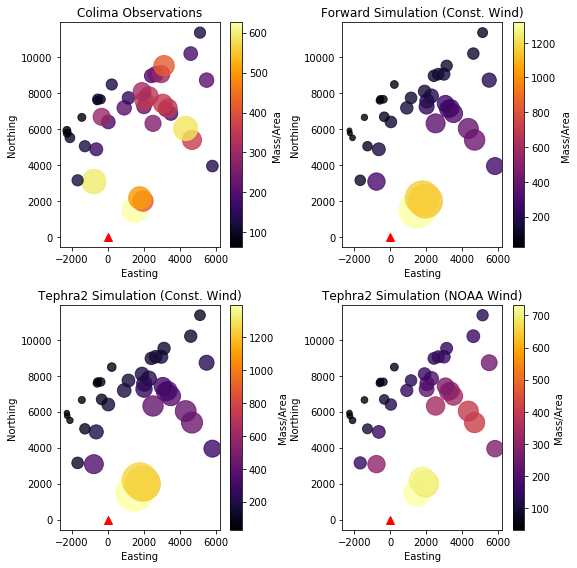

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


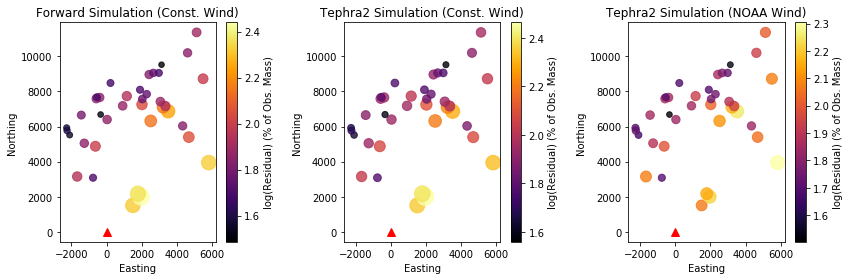

In [9]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

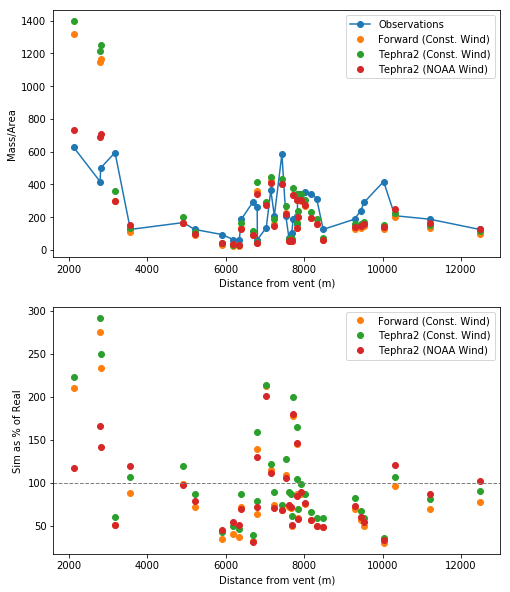

In [10]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Const. Wind Simulation========
a* = -4.46825	b* = -0.34379            	h1* = 1.85942
a = 1.01147	b = 1.70908	h1 = 25672.86688
Success: True, Optimization terminated successfully.
Iterations: 97
SSE: 2.5442766757678967


,Height,Suspended Mass
0,4430.75,5.545455e+09
1,5776.50,5.336229e+09
2,7122.25,5.101371e+09
3,8468.00,4.852079e+09
4,9813.75,4.591531e+09
5,11159.50,4.320743e+09
6,12505.25,4.039800e+09
7,13851.00,3.748221e+09
8,15196.75,3.445049e+09
9,16542.50,3.128814e+09


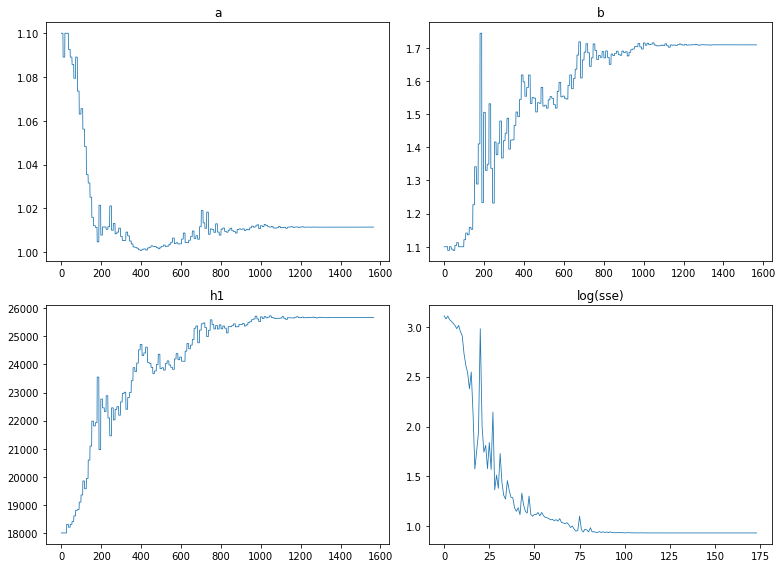

========T2 Const. Wind Simulation========
a* = -3.87239	b* = -1.06274            	h1* = 0.98235
a = 1.02081	b = 1.34551	h1 = 20630.42817
Success: True, Optimization terminated successfully.
Iterations: 91
SSE: 18.356833833623124


,Height,Suspended Mass
0,4430.75,5.631467e+09
1,5776.50,5.544622e+09
2,7122.25,5.411103e+09
3,8468.00,5.249748e+09
4,9813.75,5.064767e+09
5,11159.50,4.855912e+09
6,12505.25,4.620265e+09
7,13851.00,4.352139e+09
8,15196.75,4.041700e+09
9,16542.50,3.671254e+09


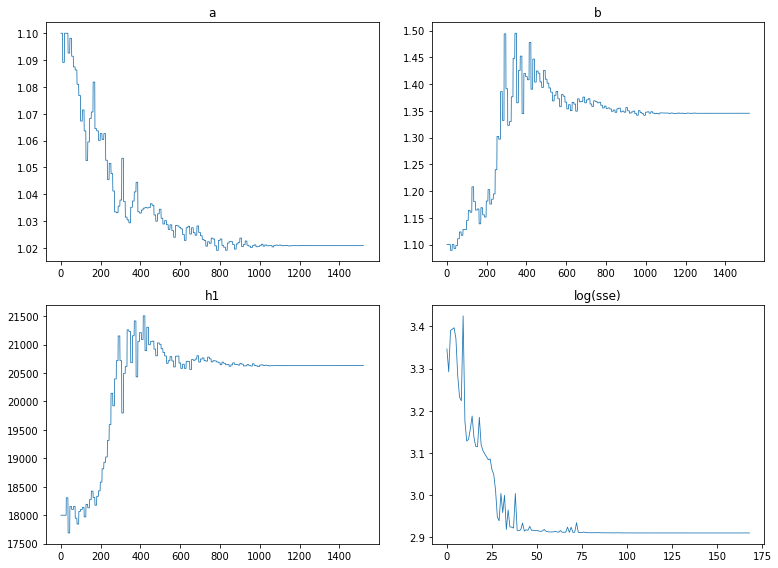

========T2 NOAA Wind Simulation========
a* = -2.20847	b* = -2.34081            	h1* = 2.54649
a = 1.10987	b = 1.09625	h1 = 27739.05709
Success: True, Optimization terminated successfully.
Iterations: 167
SSE: 240.27746558039001


,Height,Suspended Mass
0,4430.75,2.687262e+09
1,5776.50,2.883353e+09
2,7122.25,2.996411e+09
3,8468.00,3.072604e+09
4,9813.75,3.127000e+09
5,11159.50,3.166396e+09
6,12505.25,3.194346e+09
7,13851.00,3.212827e+09
8,15196.75,3.222901e+09
9,16542.50,3.225001e+09


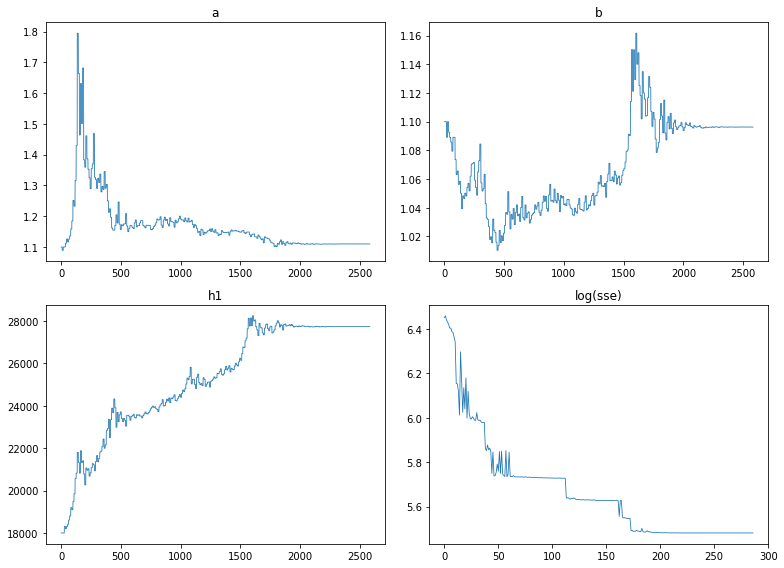

========Observation Data========
a* = -3.46477	b* = 0.79354            	h1* = 2.58686
a = 1.03128	b = 3.21121	h1 = 27825.18927
Success: True, Optimization terminated successfully.
Iterations: 112
SSE: 2665.7061900471235


,Height,Suspended Mass
0,4430.75,8.915090e+09
1,5776.50,7.991860e+09
2,7122.25,7.041704e+09
3,8468.00,6.124087e+09
4,9813.75,5.258664e+09
5,11159.50,4.454294e+09
6,12505.25,3.715501e+09
7,13851.00,3.044646e+09
8,15196.75,2.442838e+09
9,16542.50,1.910363e+09


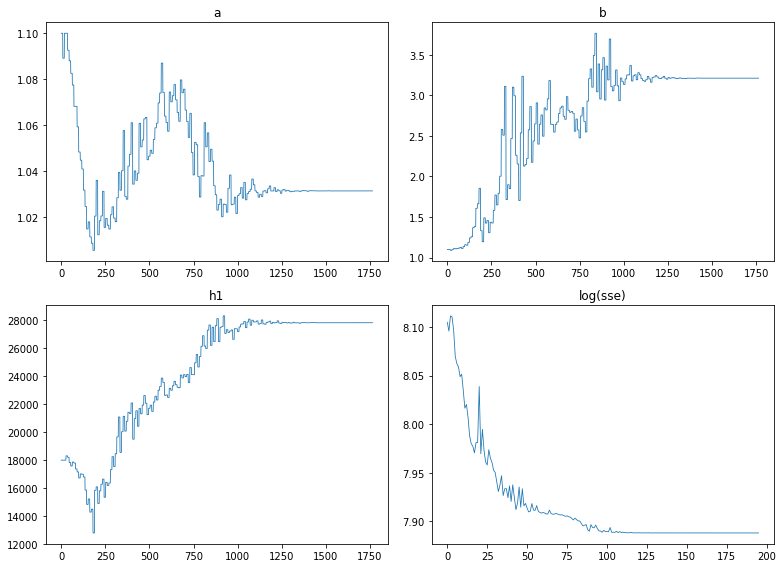

In [11]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 18000,
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Const. Wind Simulation", "T2 Const. Wind Simulation","T2 NOAA Wind Simulation", "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_plume_inversion(
        df, len(df), 20, 
        config["VENT_ELEVATION"], H, 2500,
        phi_steps, config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, params, sol, sse, trace, _, sse_trace = out
    
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



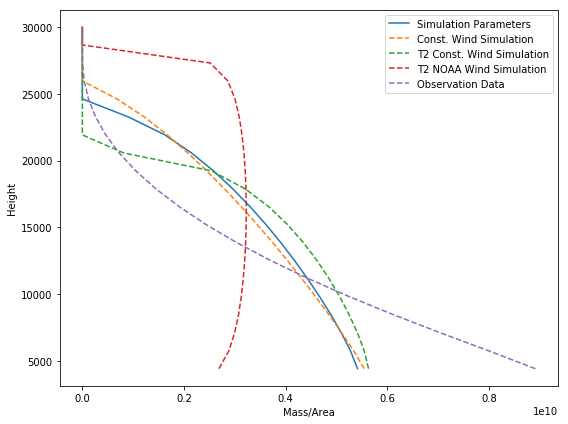

In [12]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()


========Const. Wind Simulation========


c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


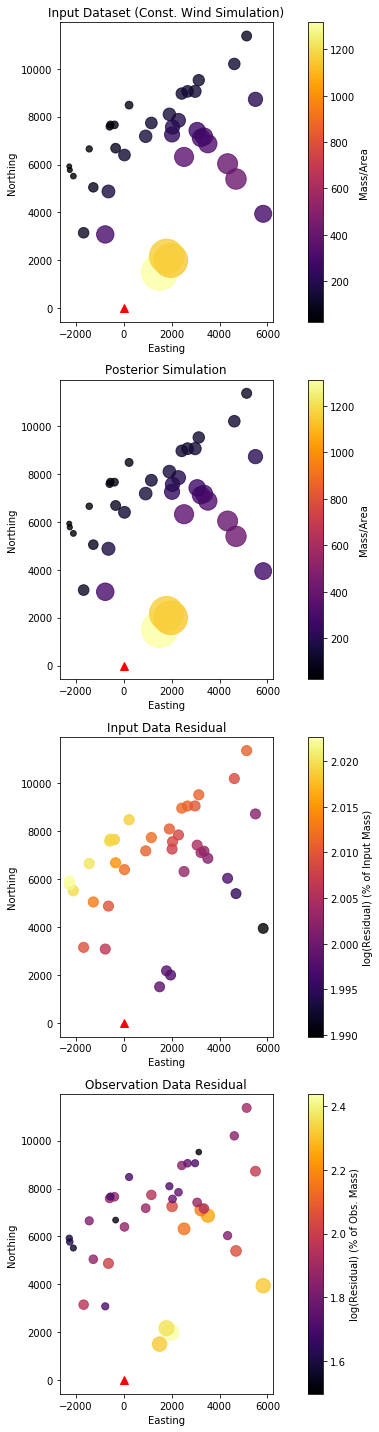

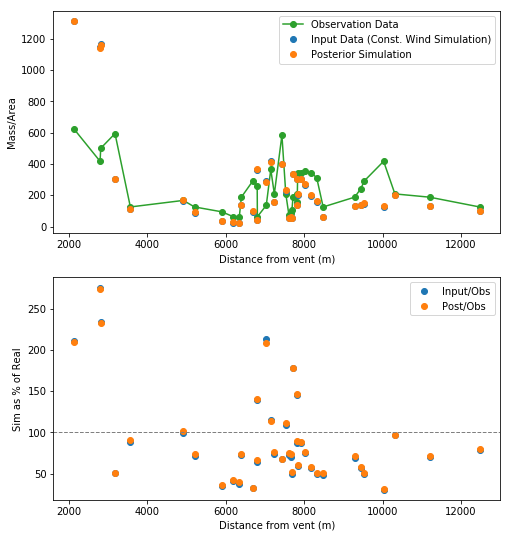

========T2 Const. Wind Simulation========


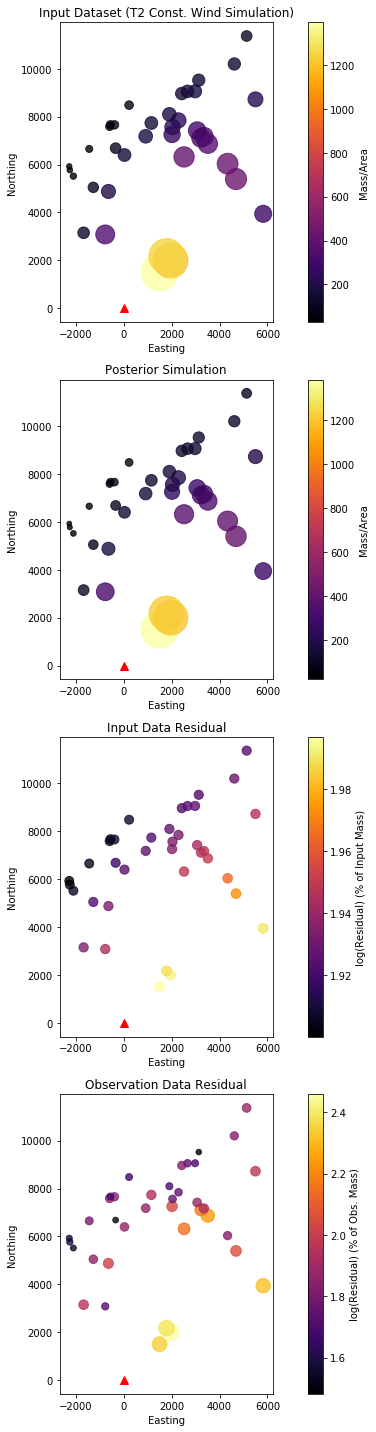

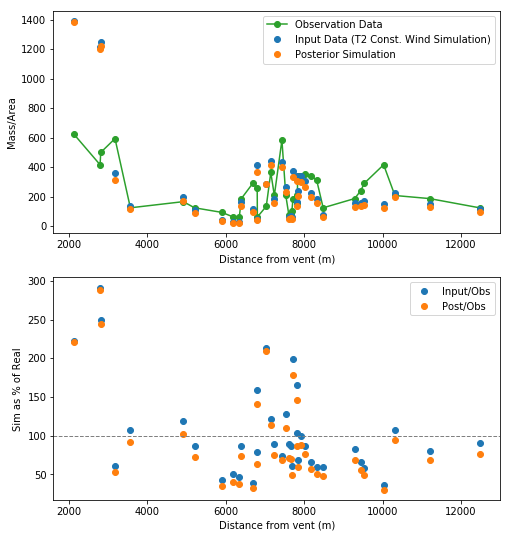

========T2 NOAA Wind Simulation========


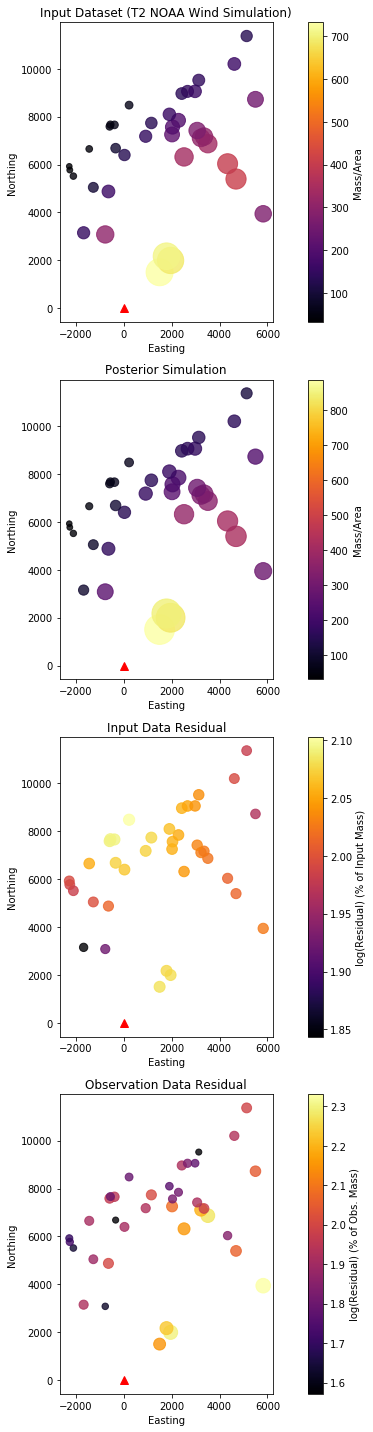

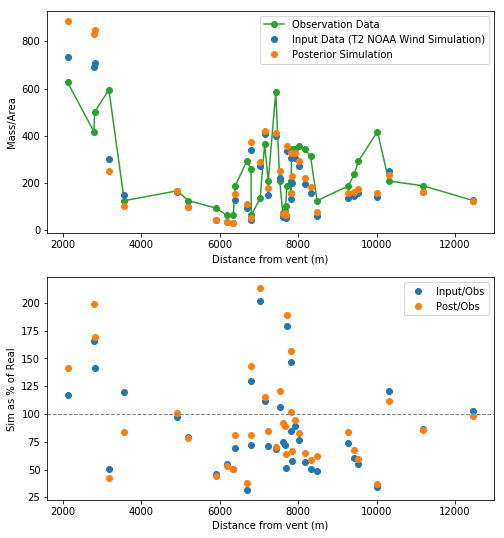

========Observation Data========


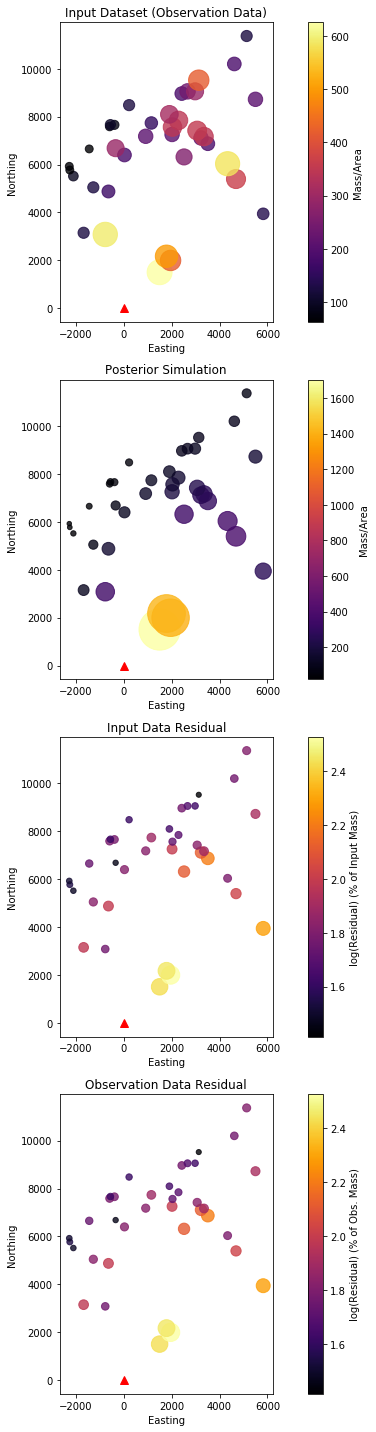

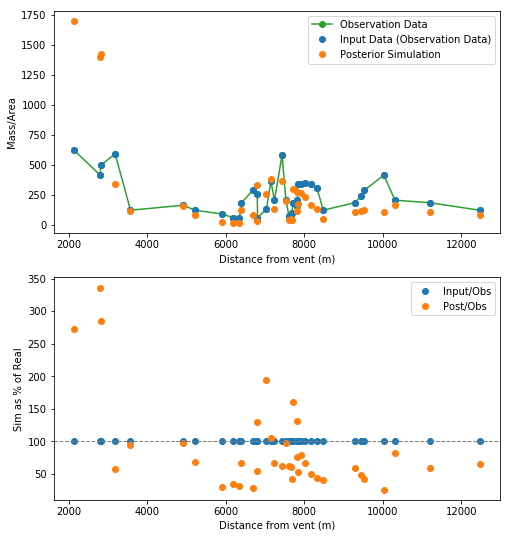

In [13]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values*100
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values*100
    
    fig, axs = plt.subplots(4,1, figsize=(
            10, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Change",
                title="Input Data Residual", cbar_label="log(Residual) (% of Input Mass)", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Residual",
                title="Observation Data Residual", cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

========Const. Wind Simulation========
a* = 0.00680	b* = 1.46547	            h1* = 5.37491	u* = 1.79864	v* = 2.08423	            D* = 8.50303	ftt* = 7.85386	TM* = 24.73060
a = 2.00682	b = 5.32958	            h1 = 29861.38173	u = 6.04144	v = 8.03842	            D = 4929.67822	ftt = 2575.64499	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 934
SSE: 41.73362082466932


,Height,Suspended Mass
0,4430.75,3.736721e+09
1,5776.50,5.933920e+09
2,7122.25,6.958600e+09
3,8468.00,7.138437e+09
4,9813.75,6.745424e+09
5,11159.50,5.998927e+09
6,12505.25,5.070590e+09
7,13851.00,4.089675e+09
8,15196.75,3.148480e+09
9,16542.50,2.307700e+09


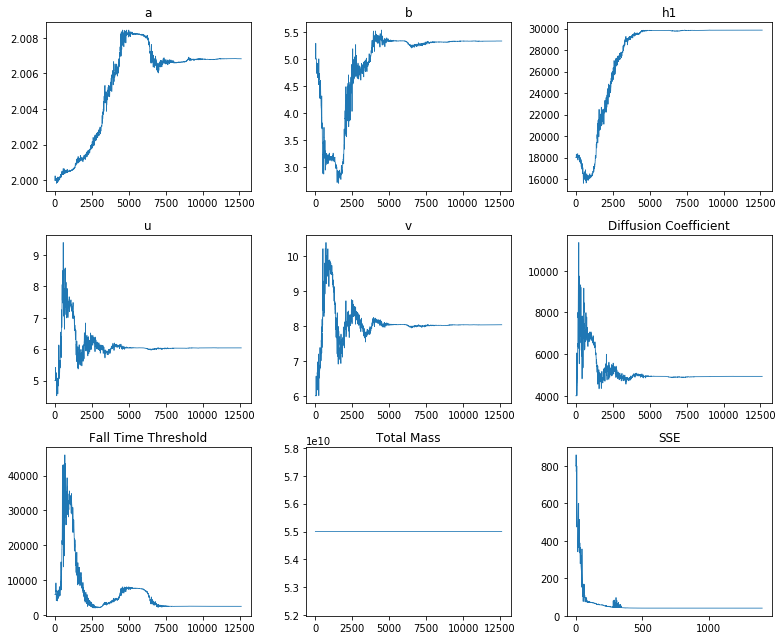

Const. Wind Simulation Run Time: 2.22604 minutes


========T2 Const. Wind Simulation========
a* = 0.00447	b* = 1.51816	            h1* = 5.41930	u* = 1.71543	v* = 2.15930	            D* = 8.42005	ftt* = 7.84414	TM* = 24.73060
a = 2.00448	b = 5.56381	            h1 = 29867.38640	u = 5.55906	v = 8.66508	            D = 4537.12827	ftt = 2550.74167	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 928
SSE: 49.446685081141034


,Height,Suspended Mass
0,4430.75,4.012293e+09
1,5776.50,6.281080e+09
2,7122.25,7.260771e+09
3,8468.00,7.338356e+09
4,9813.75,6.826629e+09
5,11159.50,5.971172e+09
6,12505.25,4.958388e+09
7,13851.00,3.923582e+09
8,15196.75,2.958777e+09
9,16542.50,2.120186e+09


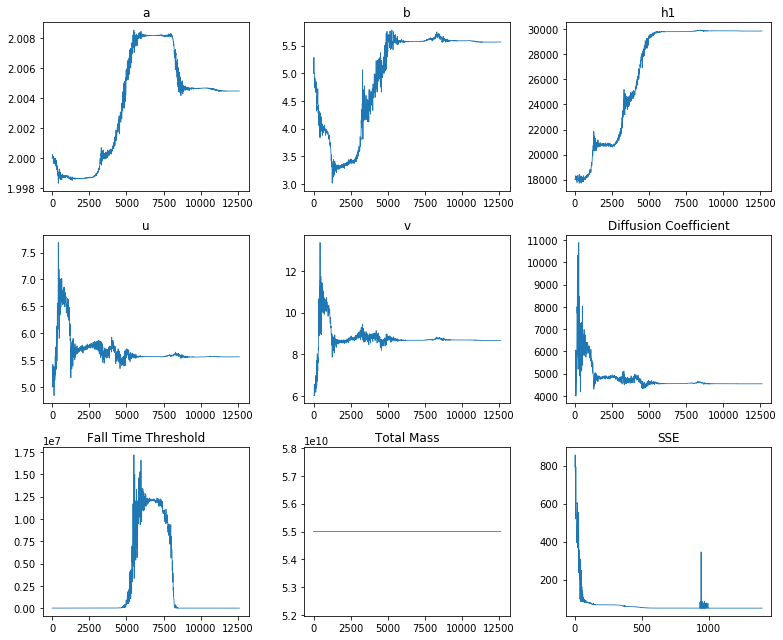

T2 Const. Wind Simulation Run Time: 2.19349 minutes


========T2 NOAA Wind Simulation========
a* = 0.00604	b* = 1.22219	            h1* = 4.81243	u* = 1.93765	v* = 2.09917	            D* = 9.09618	ftt* = 11.40865	TM* = 24.73060
a = 2.00606	b = 4.39463	            h1 = 29757.14586	u = 6.94243	v = 8.15943	            D = 8921.14159	ftt = 90098.12497	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 804
SSE: 221.37380558840758


,Height,Suspended Mass
0,4430.75,2.770554e+09
1,5776.50,4.623027e+09
2,7122.25,5.713995e+09
3,8468.00,6.198264e+09
4,9813.75,6.215827e+09
5,11159.50,5.890652e+09
6,12505.25,5.330640e+09
7,13851.00,4.627943e+09
8,15196.75,3.859445e+09
9,16542.50,3.087351e+09


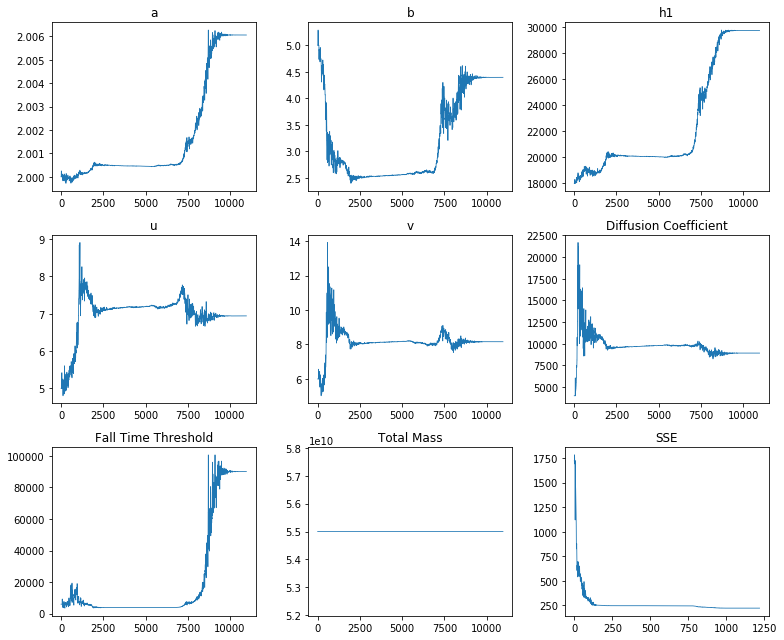

T2 NOAA Wind Simulation Run Time: 1.86458 minutes


========Observation Data========
a* = 0.00778	b* = 1.18886	            h1* = 3.16785	u* = 0.86334	v* = 1.85039	            D* = 9.19340	ftt* = 8.99912	TM* = 24.73060
a = 2.00782	b = 4.28333	            h1 = 28763.38947	u = 2.37106	v = 6.36227	            D = 9832.05312	ftt = 8095.97082	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 728
SSE: 790.3807535305634


,Height,Suspended Mass
0,4430.75,2.843077e+09
1,5776.50,4.742893e+09
2,7122.25,5.854465e+09
3,8468.00,6.336567e+09
4,9813.75,6.334171e+09
5,11159.50,5.976520e+09
6,12505.25,5.376743e+09
7,13851.00,4.631930e+09
8,15196.75,3.823415e+09
9,16542.50,3.017196e+09


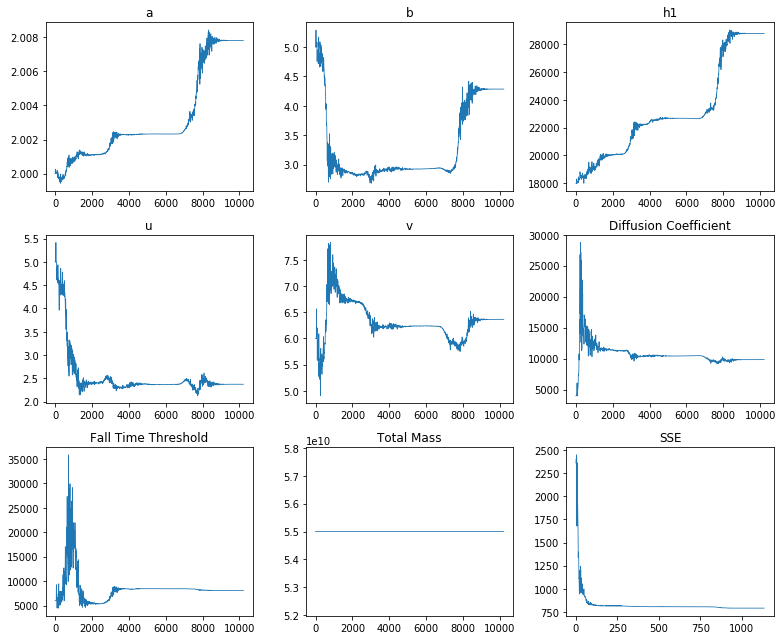

Observation Data Run Time: 1.76120 minutes


Total Run Time: 8.04531 minutes


In [14]:
priors_vals = {
    "a": 2,
    "b": 5,
    "h1": 18000,
    "u": 5,
    "v": 6,
    "D": 4000,
    "ftt": 6000,
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": True,
    "M": False
}

H = 30000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Const. Wind Simulation", 
         "T2 Const. Wind Simulation",
         "T2 NOAA Wind Simulation", 
         "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, phi_steps,
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

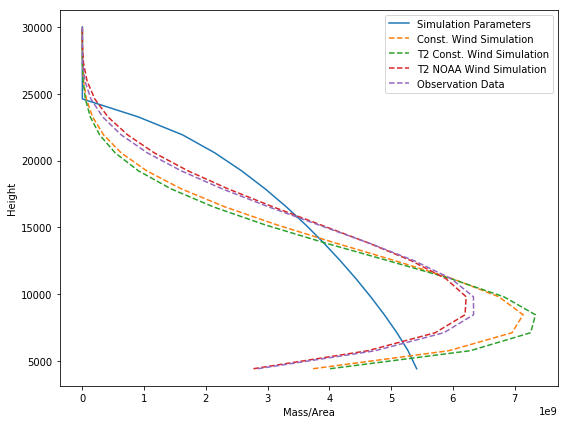

,Dataset,a,b,h1,u,v,D,ftt,M
0,Const. Wind Simulation,2.00682,5.32958,"29,861.4",6.04144,8.03842,"4,929.68","2,575.64",5.5e+10
1,T2 Const. Wind Simulation,2.00448,5.56381,"29,867.4",5.55906,8.66508,"4,537.13","2,550.74",5.5e+10
2,T2 NOAA Wind Simulation,2.00606,4.39463,"29,757.1",6.94243,8.15943,"8,921.14","90,098.1",5.5e+10
3,Observation Data,2.00782,4.28333,"28,763.4",2.37106,6.36227,"9,832.05","8,095.97",5.5e+10


In [26]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()
params_df = pd.DataFrame(params_list)
params_df["Dataset"] = names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========Const. Wind Simulation========


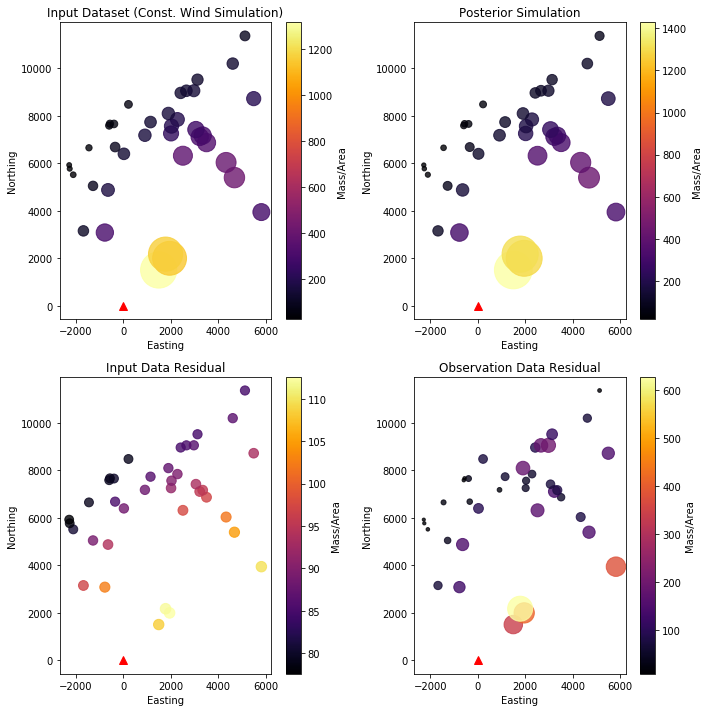

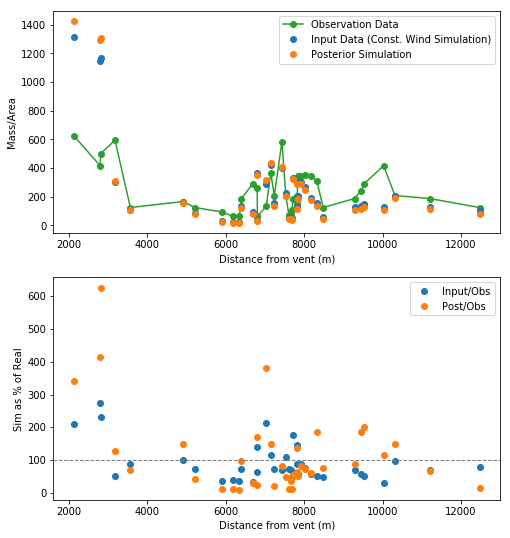

========T2 Const. Wind Simulation========


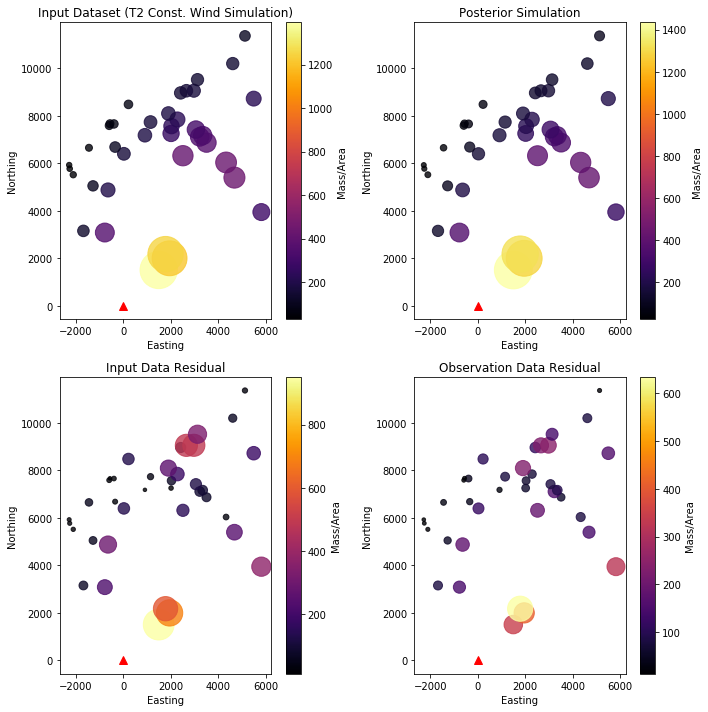

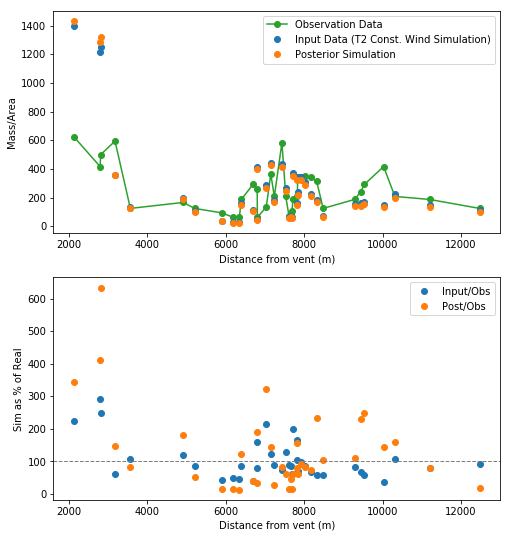

========T2 NOAA Wind Simulation========


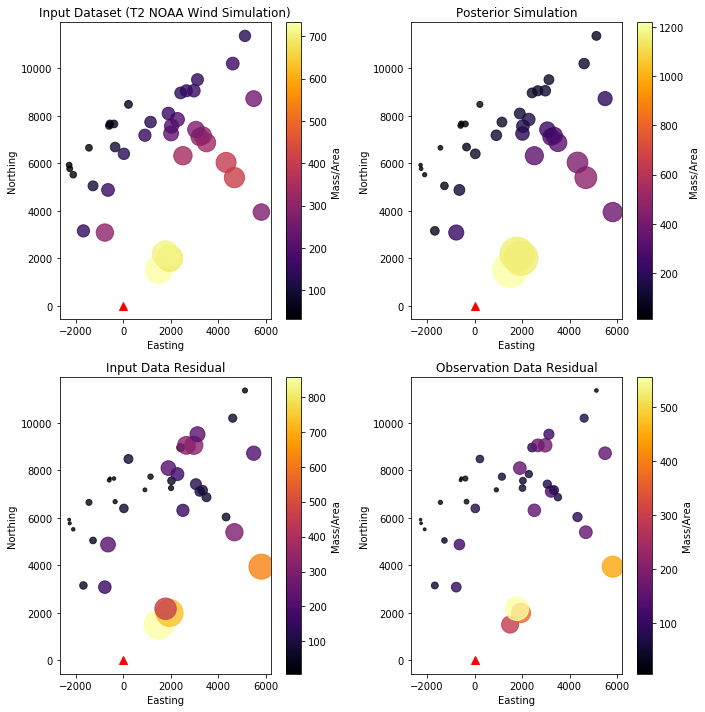

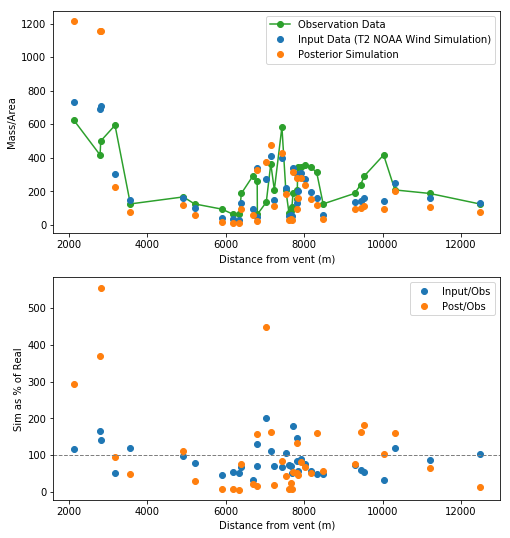

========Observation Data========


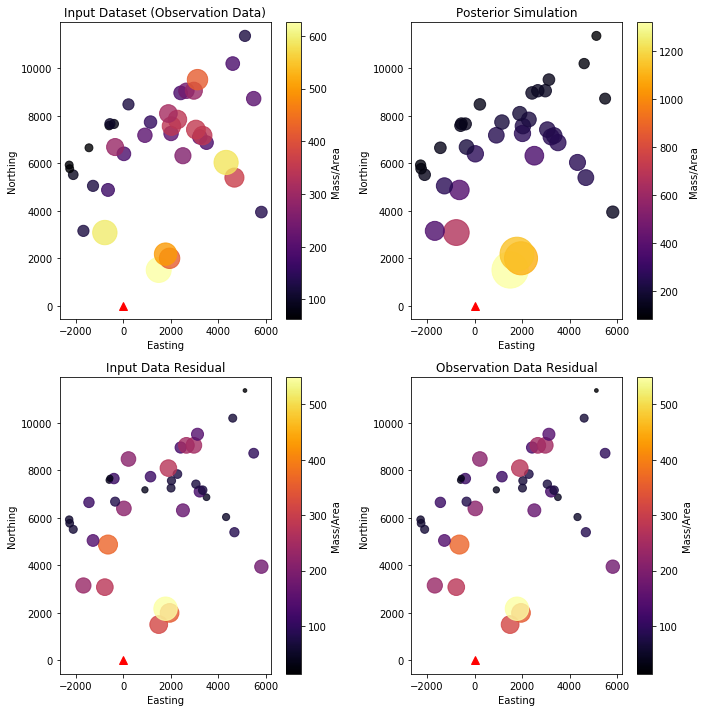

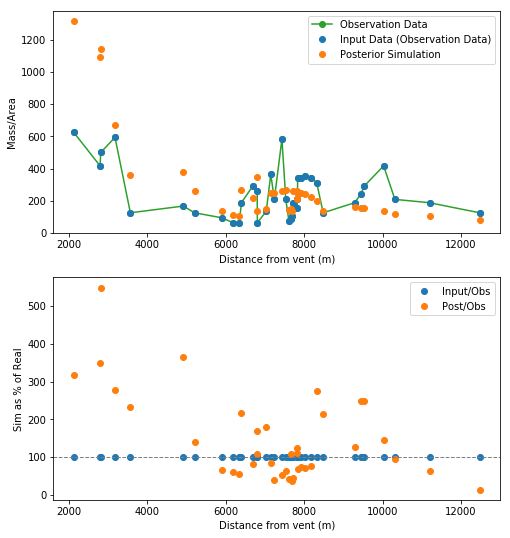

In [19]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]
    u = params["u"]
    v = params["v"]
    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"]/obs_df["MassArea"]*100
    post_df["Change"] = post_df["MassArea"]/in_data["MassArea"]*100
    
    fig, axs = plt.subplots(2,2, figsize=(
            10, 10), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Change",
                title="Input Data Residual", cbar_label="Mass/Area", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Residual",
                title="Observation Data Residual", cbar_label="Mass/Area", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    

In [ ]:


a = [1,2,3,4,5,6]

b, c, d, \
    e, f, g = a

print(b, c, d, e, f, g)